In [1]:
# # descomentar para instalar las librerias requeridas
# !pip install -r requirements.txt

# Winclap test - Deteccion de outliers
Este notebook esta dividido en 2 partes principales, al comienzo un EDA simple de los datos
y luego unos experimentos de modelos para deteccion de outlier.
Finalmente se selecciona el mejor modelo y si borran los outliers del dataset.

- cada parte tiene una conclusion de los resultados y plots.

### EDA

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_palette('bright')

In [3]:
df = pd.read_csv('Dataset-WinclapApp-TestDS.csv', parse_dates=['timestamp'])

Columns
- *app_id* = customer unique ID  
- *timestamp* = date associated to the campaign report  
- *platform* = platform where the client sends traffic to (web, android, iOS, etc)  
- *country* = target country associated to the campaign  
- *media_source* = channel where the campaign is running (facebook, google, others)  
- *spend* = amount of investment for that day on the specific campaign  
- *spend_currency* = currency of the spend (USD, ARS, etc)  
- *target_event_count* = volume of events obtained by the campaign investment associated to that date  

In [4]:
df.tail()

,app_id,timestamp,platform,country,media_source,spend,spend_currency,target_event_count
3113,winclap.com,2020-09-13,android,UK,google,2.37,USD,1
3114,winclap.com,2020-09-12,android,UK,google,2.22,USD,3
3115,winclap.com,2020-09-11,android,UK,google,6.03,USD,4
3116,winclap.com,2020-09-10,android,UK,google,3.44,USD,3
3117,winclap.com,2020-09-09,android,UK,google,4.84,USD,3


In [5]:
df.isnull().sum()

app_id                0
timestamp             0
platform              0
country               0
media_source          0
spend                 0
spend_currency        0
target_event_count    0
dtype: int64

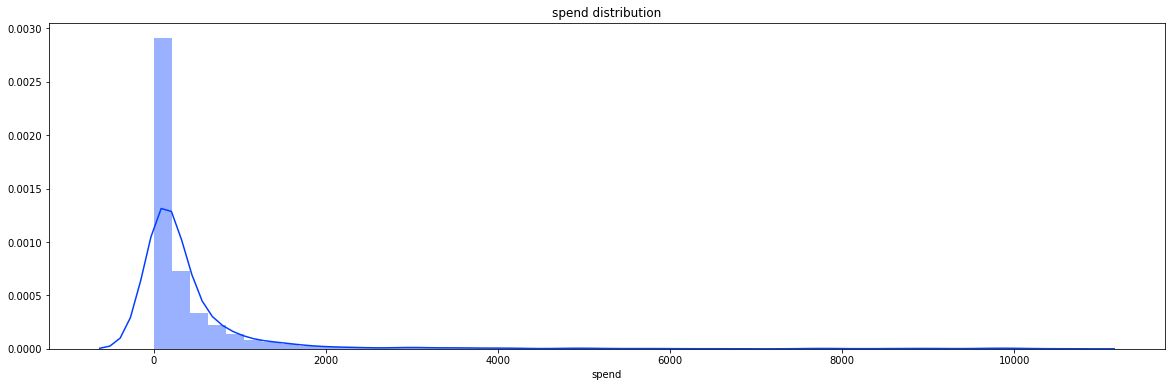

In [6]:
plt.figure(figsize=(20,6))
sns.distplot(df['spend'])
plt.title('spend distribution');

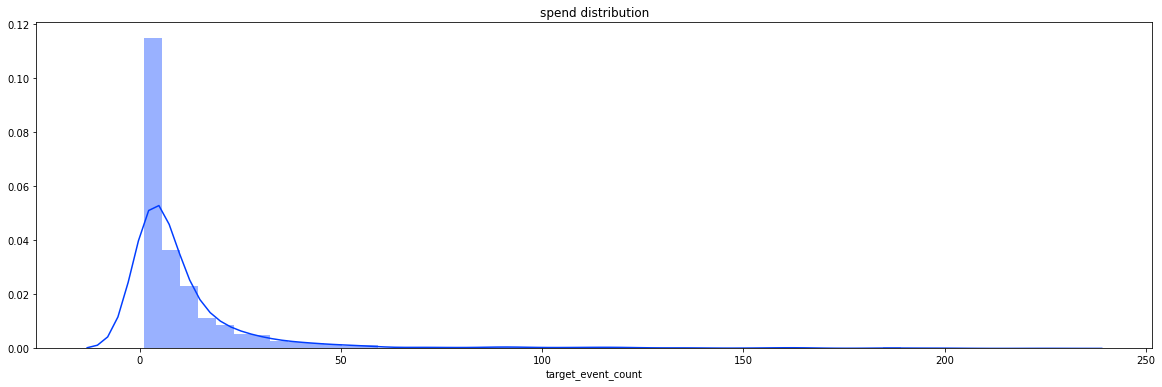

In [7]:
plt.figure(figsize=(20,6))
sns.distplot(df['target_event_count'])
plt.title('spend distribution');

#### Datos categoricos:
---

In [8]:
for col in df.drop(columns=['timestamp','target_event_count','spend']).columns:
    print(f'\n{col}:\n\t{df[col].unique()}')


app_id:
	['winclap.com']

platform:
	['android']

country:
	['AU' 'UK' 'US']

media_source:
	['pinterest' 'facebook' 'googleshopping' 'google' 'googledisplay']

spend_currency:
	['USD']


- Conclusion:  
    Vemos que muchas columnas tiene solo 1 valor, lo que no aporta nada, las dejamos con la idea de que esta no es una muestra representativa

#### Datos numericos
---

In [9]:
df.describe()

,spend,target_event_count
count,3118.000000,3118.000000
mean,448.109064,12.751123
std,1044.176914,23.445983
min,0.230000,1.000000
25%,60.597500,2.000000
50%,172.475000,5.000000
75%,378.527500,13.000000
max,10536.780000,225.000000


In [10]:
df.quantile(.95).to_frame()

,0.95
spend,1527.9505
target_event_count,47.0000


- Conclusion:  
    Hay valores muy altos en *spend* y *target_event_count* respecto al 95% de los datos

Vemos la distibucion de las fechas

In [11]:
df.timestamp.min().strftime('%d-%m-%Y'), df.timestamp.max().strftime('%d-%m-%Y')

('01-09-2020', '10-12-2020')

#### Plots
---

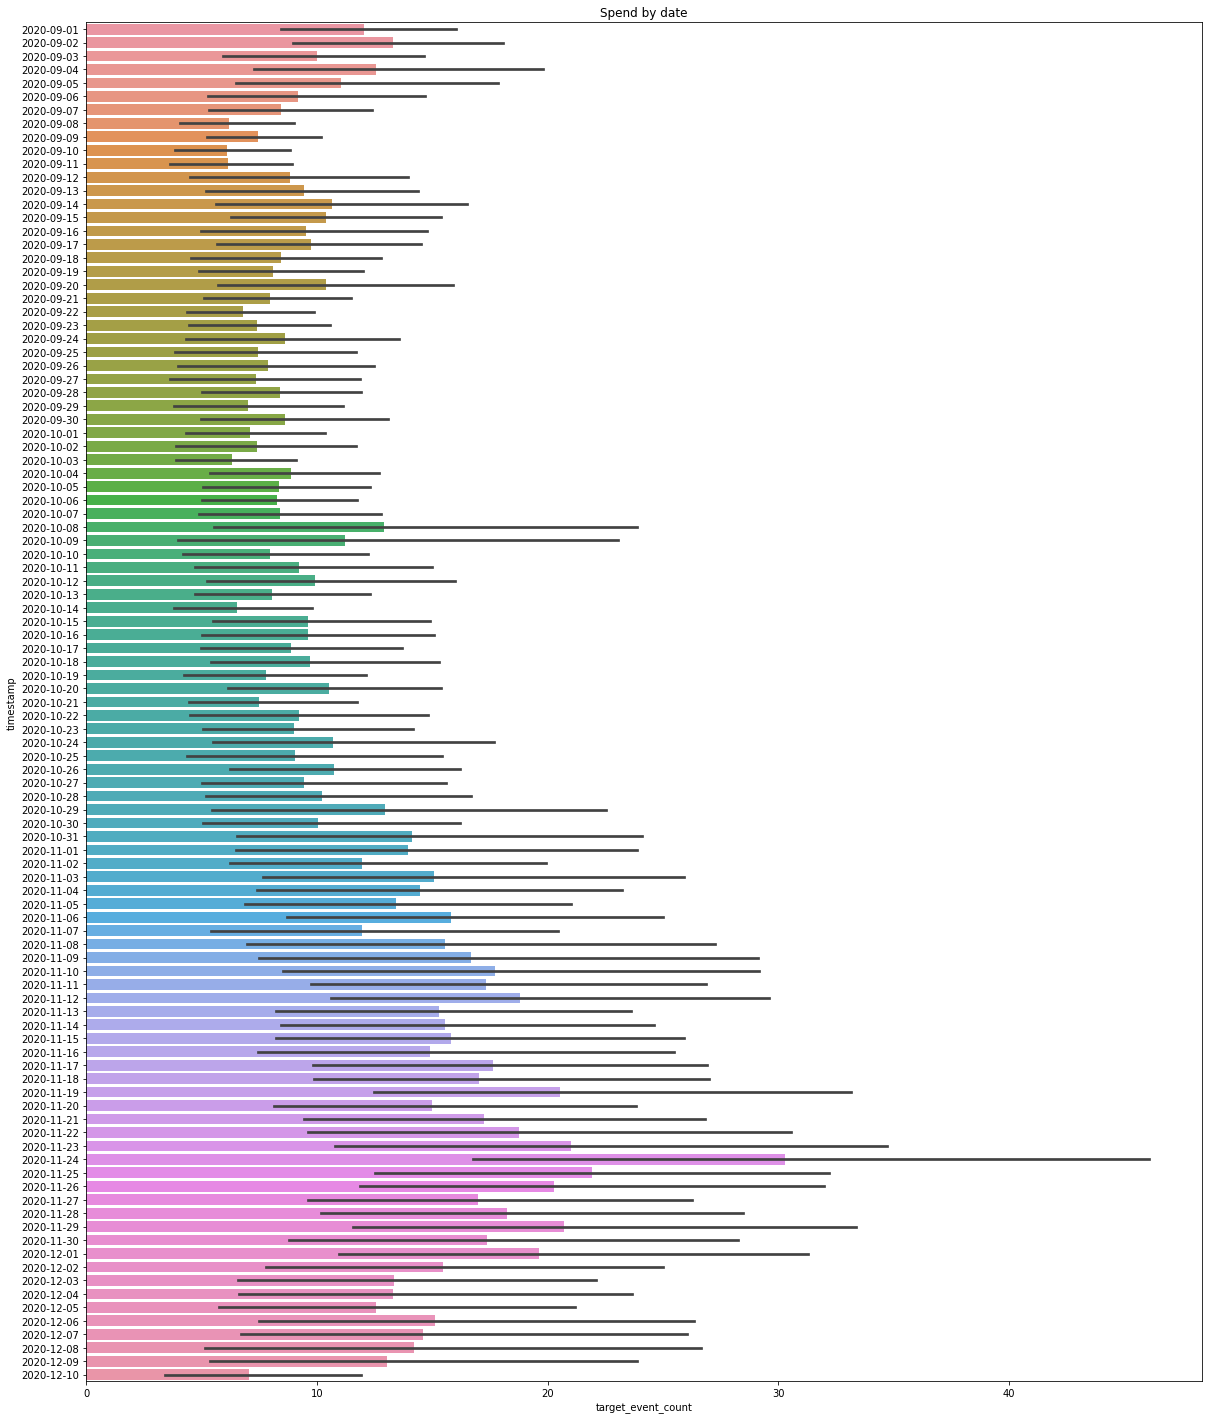

In [12]:
plt.figure(figsize=(20,25))
sns.barplot(df.sort_values(by='timestamp').target_event_count, df.sort_values(by='timestamp').timestamp.astype(str));
plt.title('Spend by date');
# plt.xticks(rotation=90);

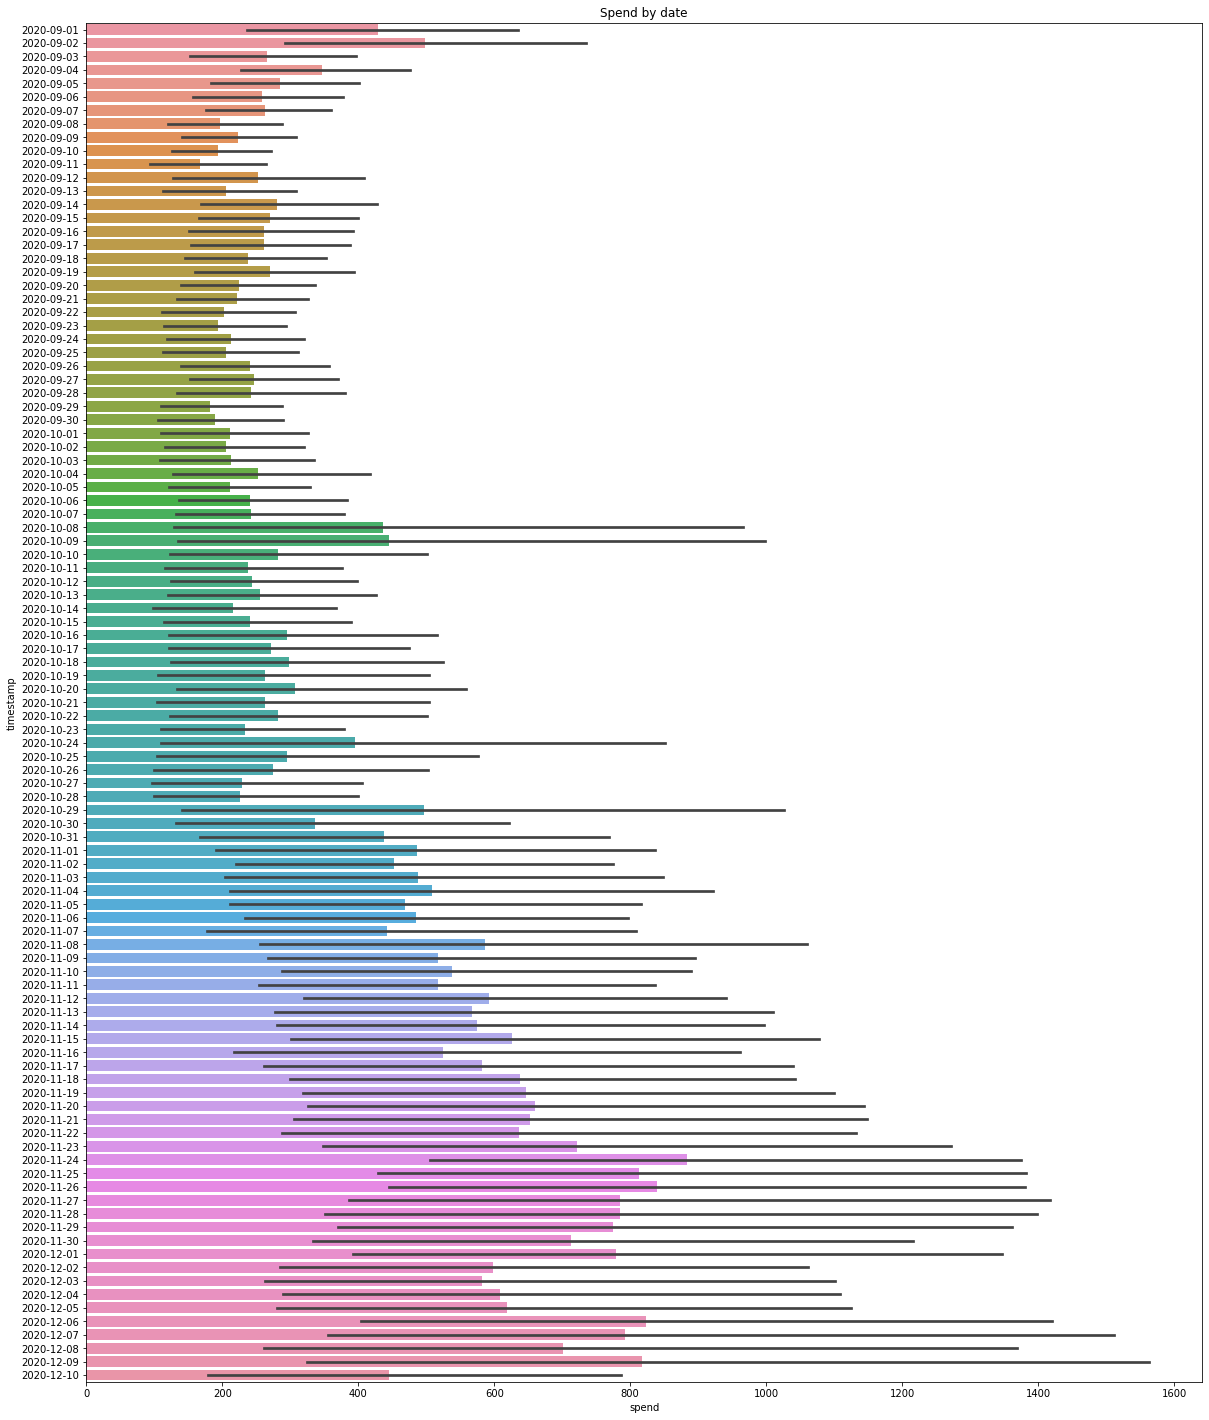

In [13]:
plt.figure(figsize=(20,25))
sns.barplot(df.sort_values(by='timestamp').spend, df.sort_values(by='timestamp').timestamp.astype(str));
plt.title('Spend by date');
# plt.xticks(rotation=90);

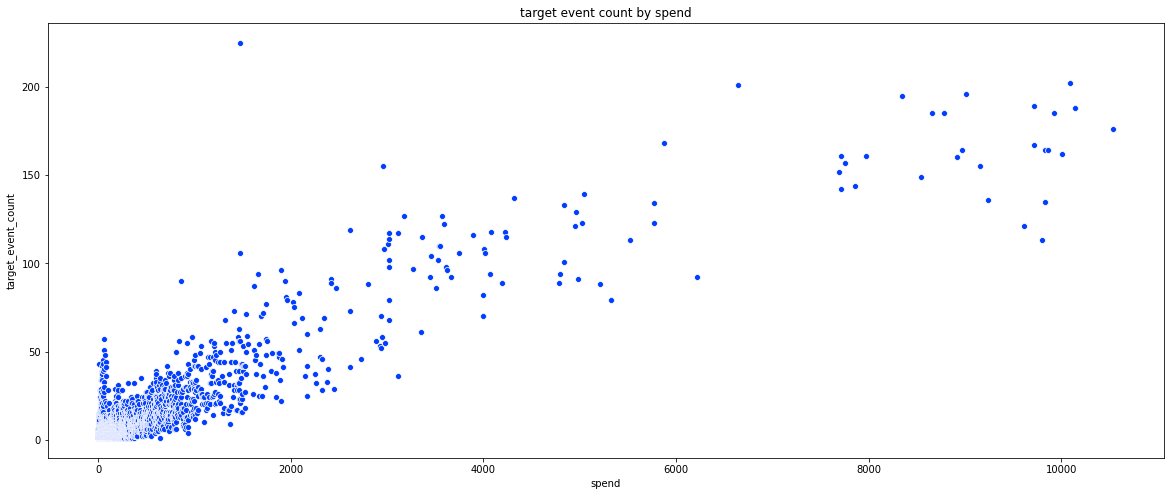

In [14]:
plt.figure(figsize=(20,8))
sns.scatterplot(df.sort_values(by='spend').spend, df.sort_values(by='spend').target_event_count);
plt.title('target event count by spend');

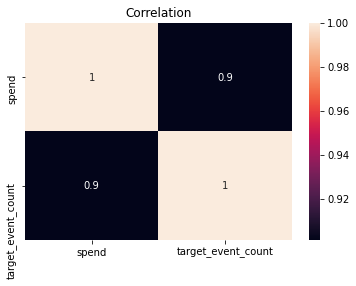

In [15]:
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation');

Claramente aumenta el spend con el tiempo, ¿puede debeberse a confianza en winclap?
A mayor spend aumenta el events_count, esta perfecto

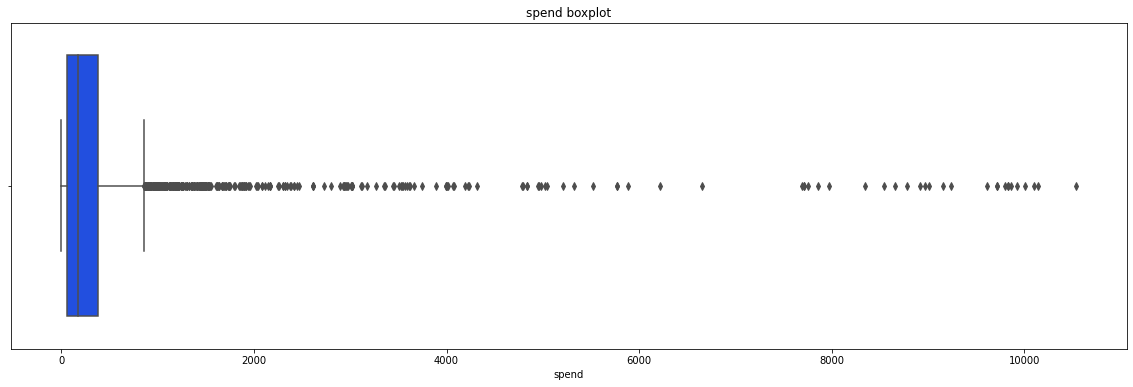

In [16]:
plt.figure(figsize=(20,6))
sns.boxplot(df.spend);
plt.title('spend boxplot');

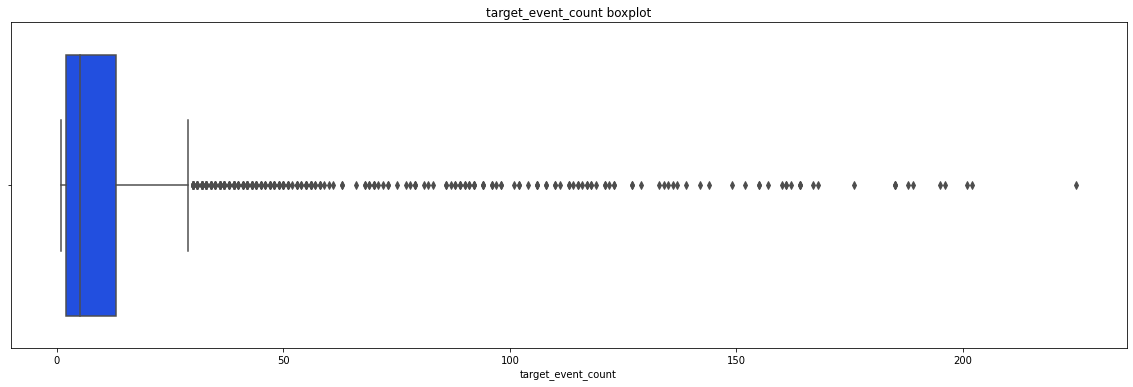

In [17]:
plt.figure(figsize=(20,6))
sns.boxplot(df.target_event_count);
plt.title('target_event_count boxplot');

BoxPlots muentran muchos valores atipicos en *spend* y *target_event_count*, aunque no tiene en cuenta los aumentos en el tiempo

In [18]:
# Agrupamos el df por 'media_source' para ver las diferentes fuentes de eventos
df_media_source = df.groupby('media_source', as_index=False)[['spend', 'target_event_count']].sum()

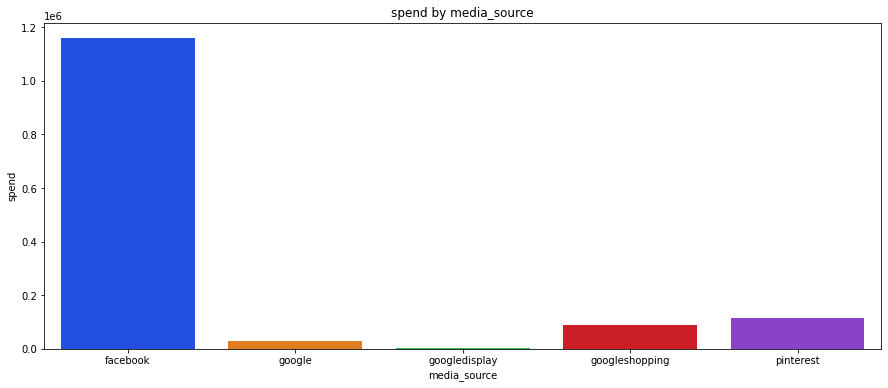

In [19]:
plt.figure(figsize=(15,6))
sns.barplot(df_media_source.media_source, df_media_source.spend);
plt.title('spend by media_source');

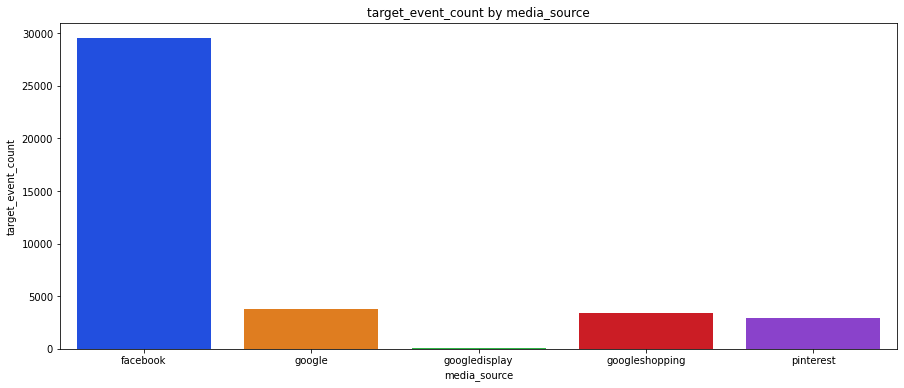

In [20]:
plt.figure(figsize=(15,6))
sns.barplot(df_media_source.media_source,
            df_media_source.target_event_count);
plt.title('target_event_count by media_source');

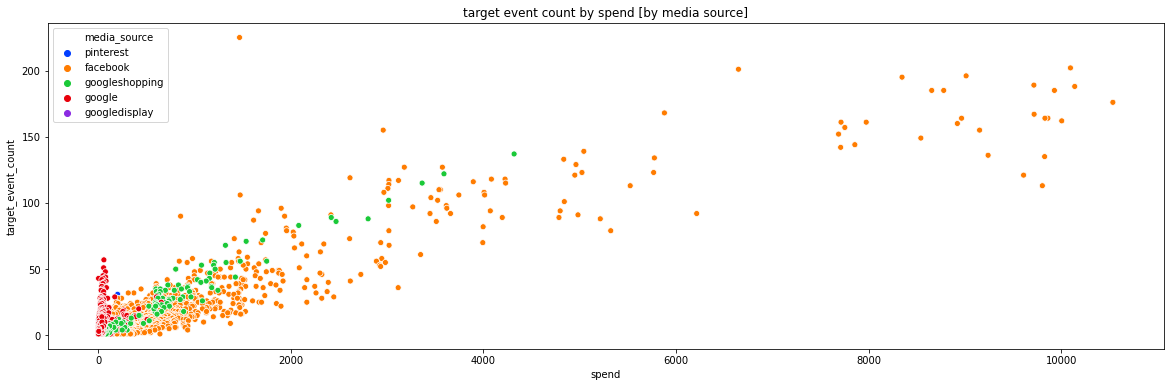

In [21]:
plt.figure(figsize=(20,6))
sns.scatterplot(df.sort_values(by='spend').spend,
                df.sort_values(by='spend').target_event_count,
                hue=df.media_source)
plt.title('target event count by spend [by media source]');

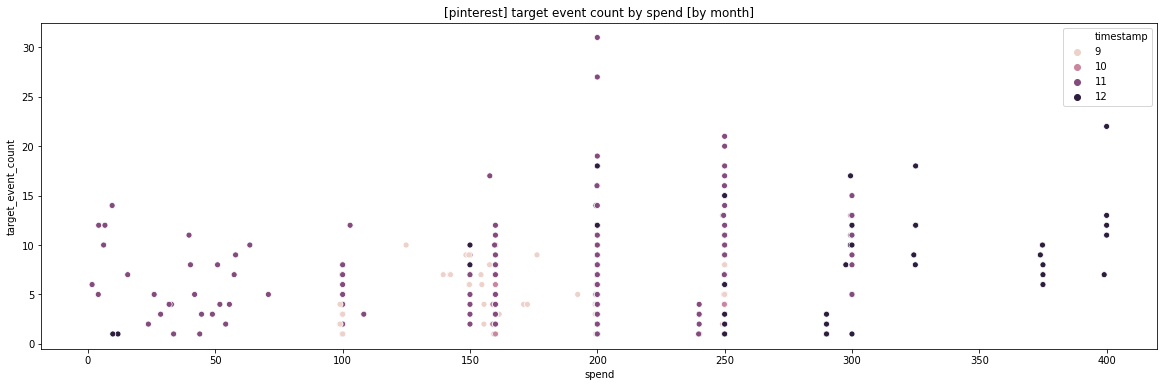

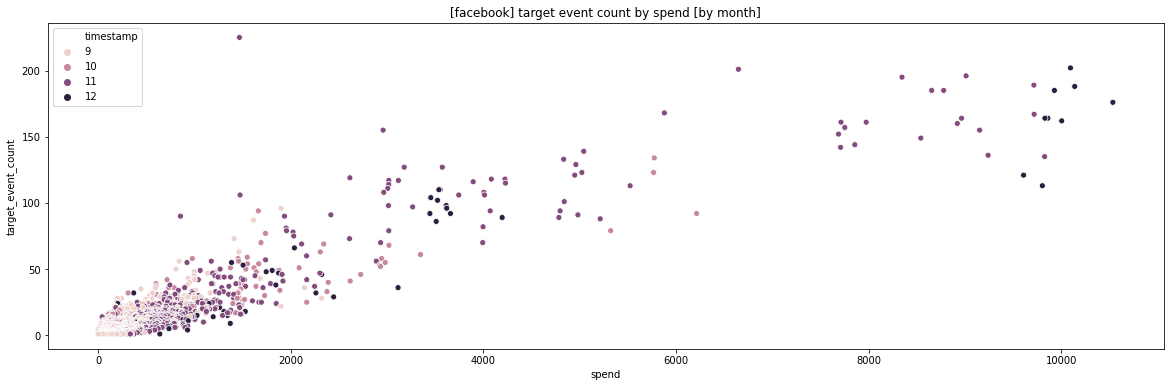

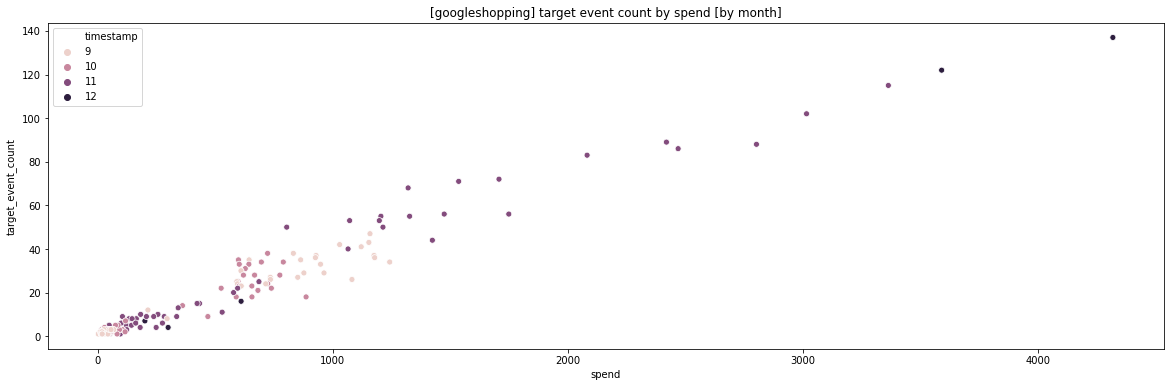

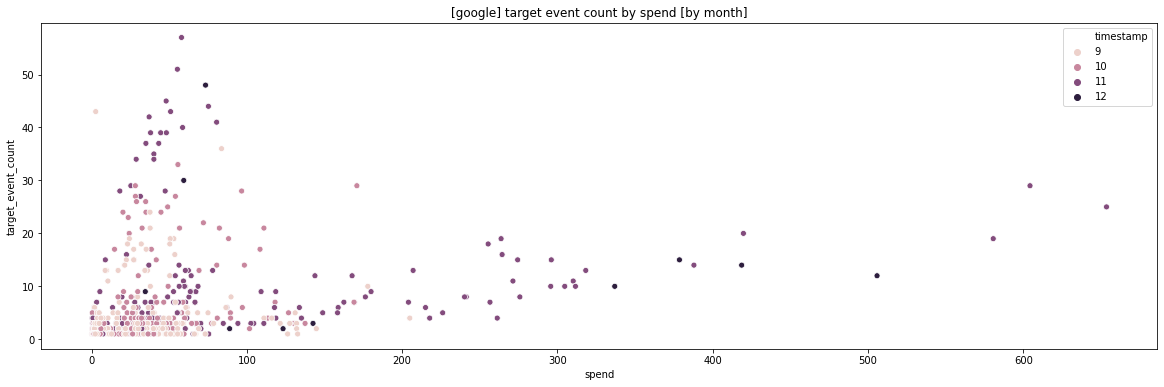

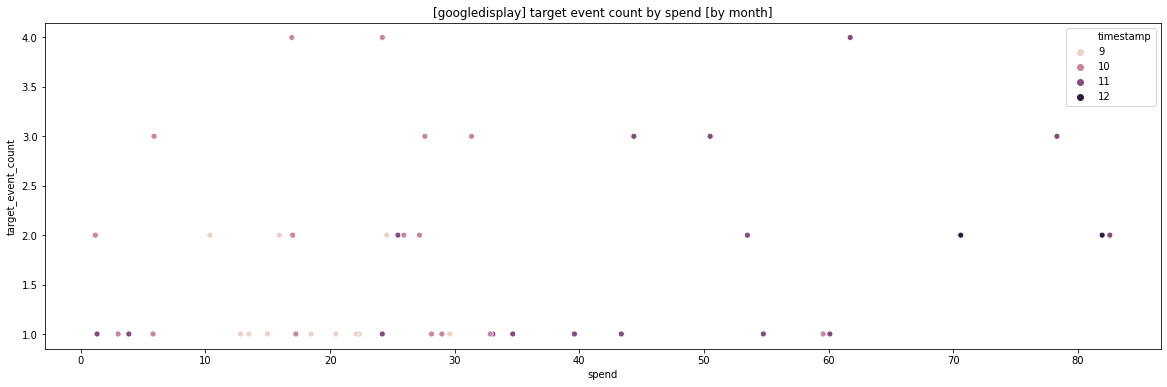

In [22]:
# Veamos con el la realacion de events_counts y spend para cada media source y los meses implicados

for media_source in df.media_source.unique():
    plt.figure(figsize=(20,6))
    sns.scatterplot(df[df.media_source == media_source].spend,
                    df[df.media_source == media_source].target_event_count,
#                     size=df[df.media_source == media_source].timestamp.dt.month,
                    hue=df[df.media_source == media_source].timestamp.dt.month)
    plt.title(f'[{media_source}] target event count by spend [by month]');

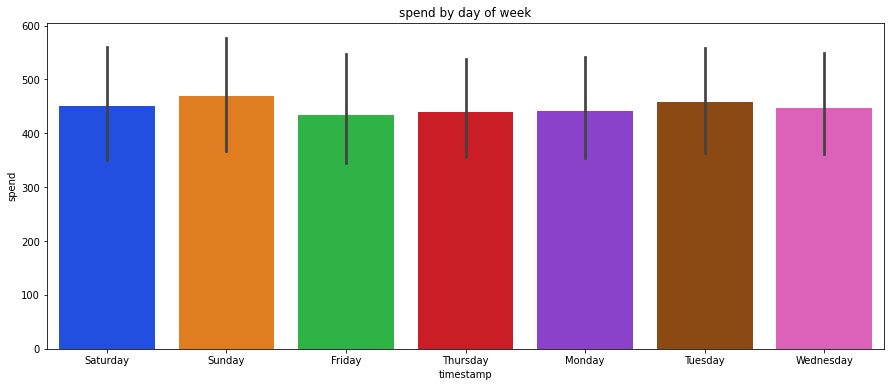

In [23]:
plt.figure(figsize=(15,6))
sns.barplot(df.timestamp.dt.day_name(), df.spend)
plt.title('spend by day of week');

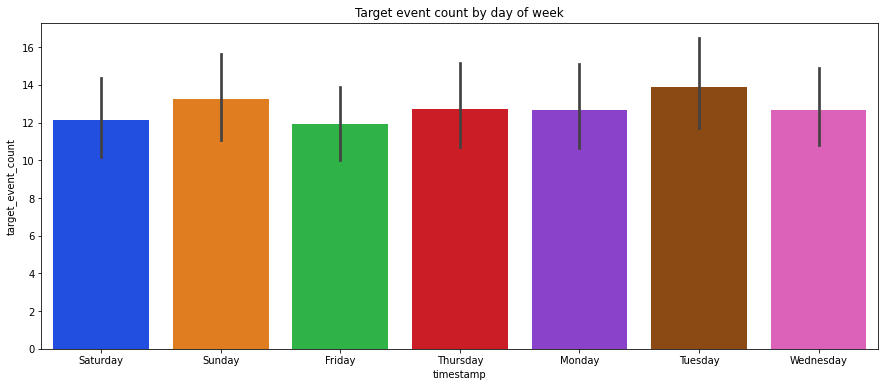

In [24]:
plt.figure(figsize=(15,6))
sns.barplot(df.timestamp.dt.day_name(), df.target_event_count)
plt.title('Target event count by day of week');

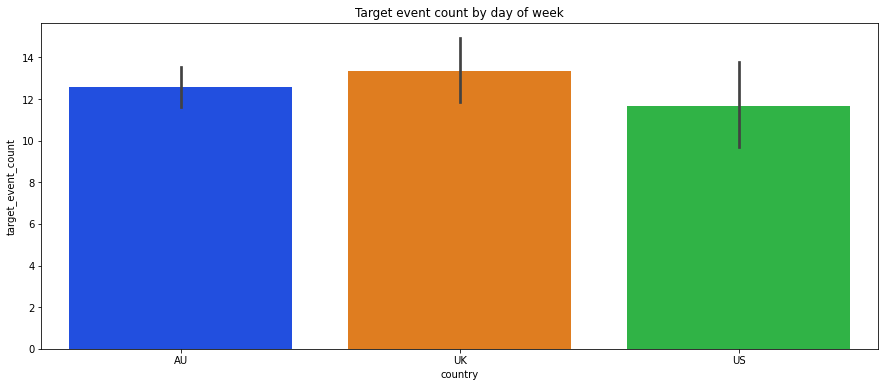

In [25]:
plt.figure(figsize=(15,6))
sns.barplot(df.country, df.target_event_count)
plt.title('Target event count by day of week');

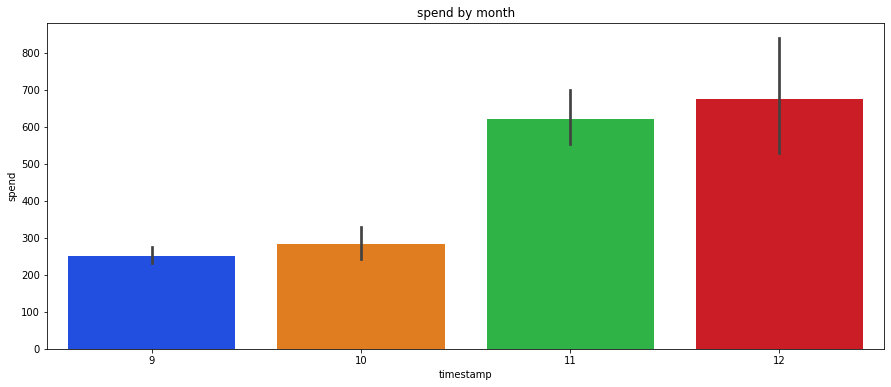

In [26]:
plt.figure(figsize=(15,6))
sns.barplot(df.timestamp.dt.month, df.spend)
plt.title('spend by month');

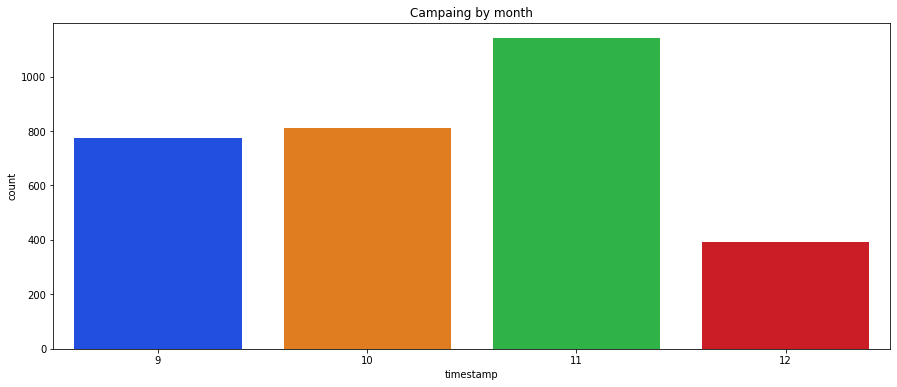

In [27]:
plt.figure(figsize=(15,6))
sns.countplot(df.timestamp.dt.month)
plt.title('Campaing by month');

---
#### Conclusion:
    - Vemos una tendencia creciente en el monto invertido (spend) a travez del tiempo.
    - Vemos una clara correlacion entre el monto invertido y los eventos conseguidos.
    - Vemos que la mayor campaña se realiza sobre facebook, lo es correcto por el flujo de usuarios.
    - No hay paises ni dias de la semana donde los eventos sean muy por encima de la media.
    - El en ultimo mes de los datos el spend sigue subiendo pero tenemos menos datos, lo que puede hacer que los algoritmos tomen esto como outliers.
   
    Los outliers pueden vernir de dias donde el no se correlacionen el spend y target_event_count, vamos a buscar outlier de forma tradiccional o con algunos modelos de ML.
    
Tomamos las siguientes columnas a fin de poder usar el modelo con cualquier cliente en un futuro

In [28]:
df_outliers = df[['spend', 'target_event_count', 'media_source', 'country']].copy()
df_outliers['month'] = df.timestamp.dt.month
df_outliers['day_week'] = df.timestamp.dt.dayofweek

In [29]:
df_outliers.tail()

,spend,target_event_count,media_source,country,month,day_week
3113,2.37,1,google,UK,9,6
3114,2.22,3,google,UK,9,5
3115,6.03,4,google,UK,9,4
3116,3.44,3,google,UK,9,3
3117,4.84,3,google,UK,9,2


Convertimos las columnas categoricas, usamos one-hot-encoder ya que algunos modelos se basan en distancia y no queremos dar una idea equivocada de los datos al modelo.

In [30]:
df_outliers = pd.get_dummies(df_outliers, columns=['country', 'media_source'])
df_outliers.head(3)

,spend,target_event_count,month,day_week,country_AU,country_UK,country_US,media_source_facebook,media_source_google,media_source_googledisplay,media_source_googleshopping,media_source_pinterest
0,100.0,2,9,5,1,0,0,0,0,0,0,1
1,300.0,9,12,6,1,0,0,0,0,0,0,1
2,300.0,1,12,5,1,0,0,0,0,0,0,1


## StandarScaler
Este sera el primer modelo de deteccion de outlier usando la regla de las [3 sigmas](https://es.wikipedia.org/wiki/Regla_68-95-99.7#:~:text=En%20las%20ciencias%20emp%C3%ADricas%2C%20la,tratar%20el%2099.7%25%20de%20probabilidad)  

\begin{aligned}\Pr(\mu -3\sigma \leq X\leq \mu +3\sigma )&\approx 0.9973\end{aligned}

- Este modelo funciona por columnas individuales, por la tanto solo tiene sentido aplicarlo a *spend*, *target_event_count*

In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
scaler = StandardScaler()

X = scaler.fit_transform(df_outliers[['spend', 'target_event_count']])
X = pd.DataFrame(X, columns=['spend', 'target_event_count'])

X_sum = (X>3).abs().sum()
X_sum.name = 'Outliers count'
X_sum.to_frame()

,Outliers count
spend,60
target_event_count,87


#### Filas con multi-variante outliers

In [33]:
outlier_mask = (X.spend.abs() > 3) & (X.target_event_count.abs() > 3)   # mas de 3 sigmas en ambas columnas
df.loc[outlier_mask].head()

,app_id,timestamp,platform,country,media_source,spend,spend_currency,target_event_count
620,winclap.com,2020-12-02,android,AU,facebook,10096.13,USD,202
621,winclap.com,2020-11-12,android,AU,facebook,6648.37,USD,201
622,winclap.com,2020-11-22,android,AU,facebook,9012.60,USD,196
623,winclap.com,2020-11-19,android,AU,facebook,8347.11,USD,195
624,winclap.com,2020-11-29,android,AU,facebook,9716.39,USD,189


Text(0.5, 1.0, 'Outliers - 3 Sigmas')

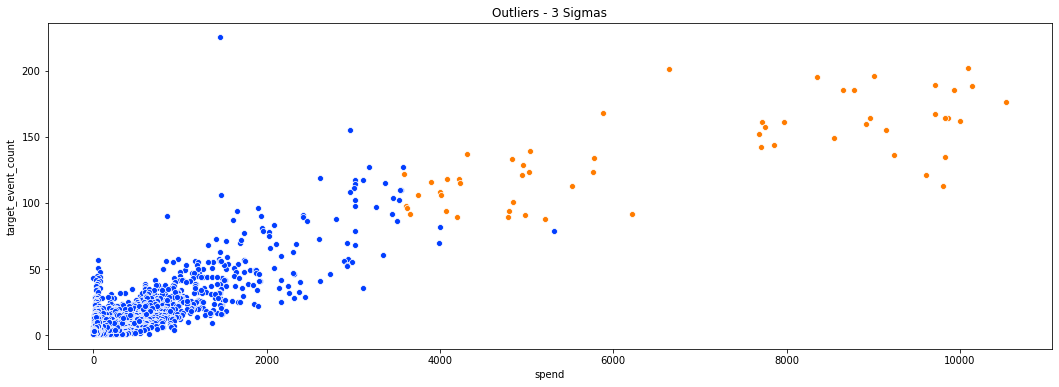

In [34]:
plt.figure(figsize=(18,6))
sns.scatterplot(df.loc[~outlier_mask].spend,
                df.loc[~outlier_mask].target_event_count)

sns.scatterplot(df.loc[outlier_mask].spend,
                df.loc[outlier_mask].target_event_count)
plt.title('Outliers - 3 Sigmas')

- Conclusion:  
    Claramente esta marcando como outliers los valores mas altos, esto esta mal ya que el spend va aumentando con el tiempo, y la razon que los valores mas altos esten tan alaejados es que tenemos menos datos en ese periodo.

## [DBSCAN](https://es.wikipedia.org/wiki/DBSCAN)
Es un modelo para clustering basado en la densidad de las muestras. Util para deteccion de outliers, el modelo marca puntos que no se encuentren en ningun grupo como valores atipicos.

In [35]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [36]:

for i in range(10):
    eps = np.random.random()+np.random.randint(2, 20)
    min_samples = np.random.randint(3, 15)
    
    dbscan = DBSCAN(eps=eps,
                    min_samples=min_samples)
    dbscan.fit(df_outliers)
    
    print(f'Iteration {i}: eps={eps:0.2f}, min_samples={min_samples:0.2f}')
    
    if len(set(dbscan.labels_)) > 1:
        print(silhouette_score(df_outliers, dbscan.labels_))

Iteration 0: eps=3.27, min_samples=12.00
-0.08044486495473056
Iteration 1: eps=7.26, min_samples=6.00
-0.2819321629823053
Iteration 2: eps=3.09, min_samples=6.00
-0.10712131435317208
Iteration 3: eps=13.62, min_samples=14.00
0.4840174930078384
Iteration 4: eps=4.59, min_samples=7.00
0.05379453130242056
Iteration 5: eps=11.70, min_samples=14.00
0.44969103427481966
Iteration 6: eps=2.49, min_samples=14.00
-0.3146932924566502
Iteration 7: eps=7.39, min_samples=9.00
0.2931698877290841
Iteration 8: eps=2.42, min_samples=7.00
-0.23038751174352676
Iteration 9: eps=16.30, min_samples=3.00
0.5873421825761613


In [37]:
dbscan = DBSCAN(eps=18, min_samples=20)
dbscan.fit(df_outliers)

print(silhouette_score(df_outliers, dbscan.labels_))

0.5592184692448741


In [38]:
pd.Series(dbscan.labels_).value_counts()

 0    2747
-1     351
 1      20
dtype: int64

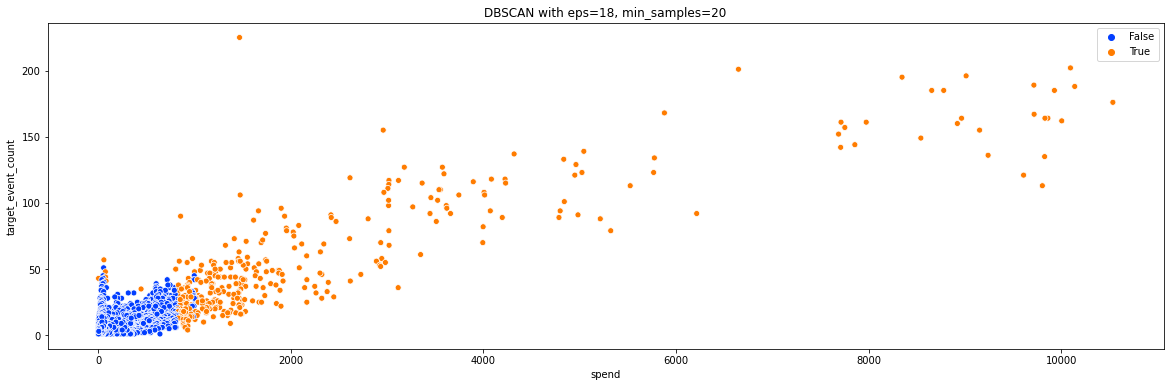

In [39]:
plt.figure(figsize=(20,6))
sns.scatterplot(df.spend,
                df.target_event_count,
                hue=dbscan.labels_==-1)
plt.title(f'DBSCAN with eps=18, min_samples=20');

- Conclusion:  
    La variacion en la densidad de puntos no permite el buen funcionamiento de este algoritmo.

## IsolationForest
Un modelo basado en Arboles para la deteccion de outlier, el modelo va tomando caracteristicas de las muestas y separa las que estan alejadas de los max y min.

In [40]:
from sklearn.ensemble import IsolationForest

Vamos a probar los hiperparametros del modelo y buscar la mejor combinacion buscando modelo que detecto menor cantidad de outliers

In [41]:
results = {}

for i, estimators in enumerate(np.arange(25, 250, 25)):
    for bootstrap in [True, False]:
        for max_samples in ['auto', .2, .5, .9]:

            iso = IsolationForest(n_estimators=estimators, max_samples=max_samples, bootstrap=bootstrap, n_jobs=-1)
            X = iso.fit_predict(df_outliers)
            
            results[i] = {'n_estimators': estimators,
                          'max_samples': max_samples, 
                          'bootstrap': bootstrap,
                          'outliers': (X==-1).sum()
                         }

print(f'Trained {len(results)} models')

best_iter = min(results.values(), key=lambda x: x['outliers'])
print(f'best params: {best_iter}' )

Trained 9 models
best params: {'n_estimators': 50, 'max_samples': 0.9, 'bootstrap': False, 'outliers': 700}


In [42]:
del best_iter['outliers']
iso = IsolationForest(**best_iter, n_jobs=-1)
X = iso.fit_predict(df_outliers)

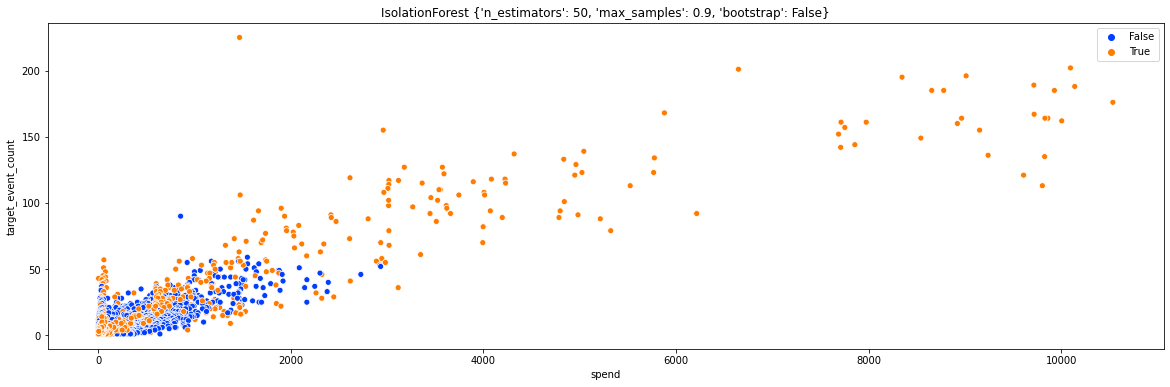

In [43]:
plt.figure(figsize=(20,6))
sns.scatterplot(df.spend,
                df.target_event_count,
                hue=X==-1)
plt.title(f'IsolationForest {best_iter}');

- Conclusion:  
    Si el modelo funciona bien no tiene el cuenta la tendencia creciente de los valores en *spend* y *target_event_count*

## IsolationForest with PCA

In [44]:
from sklearn.decomposition import PCA

In [45]:
pca = PCA(n_components=2)
X = pca.fit_transform(df_outliers)

In [46]:
iso = IsolationForest(**best_iter, n_jobs=-1)
X = iso.fit_predict(np.sqrt(np.abs(X)))

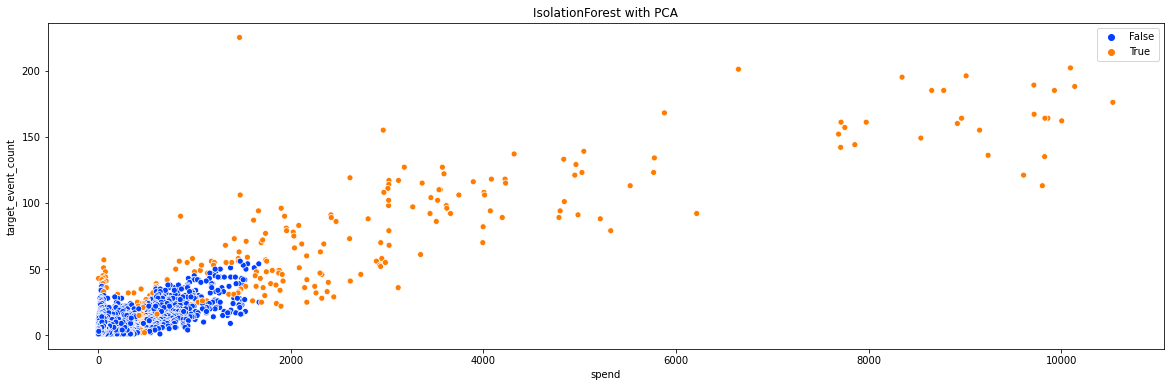

In [47]:
plt.figure(figsize=(20,6))
sns.scatterplot(df.spend,
                df.target_event_count,
                hue=X==-1)
plt.title(f'IsolationForest with PCA');

## LocalOutlierFactor
El modelo funciona comparando las distancias que tiene una muestra con sus n vecinos mas cercanos respecto a las distancias entre esos vecinos.
Puede llegar a funcionar ya que no afectaria la variacion de densidad entre las muestras, ni la tendencia creciente de *spend* y *event_count*

In [48]:
from sklearn.neighbors import DistanceMetric, LocalOutlierFactor

Vamos a crear un modelo con *n_neighbors=20* (valor recomendado por la libreria sklearn) usando como metrica la [*correlacion*](https://en.wikipedia.org/wiki/Correlation_and_dependence) de las variables, ya que se asumen valores atipicos cuando la correlacion de las variables cambia.

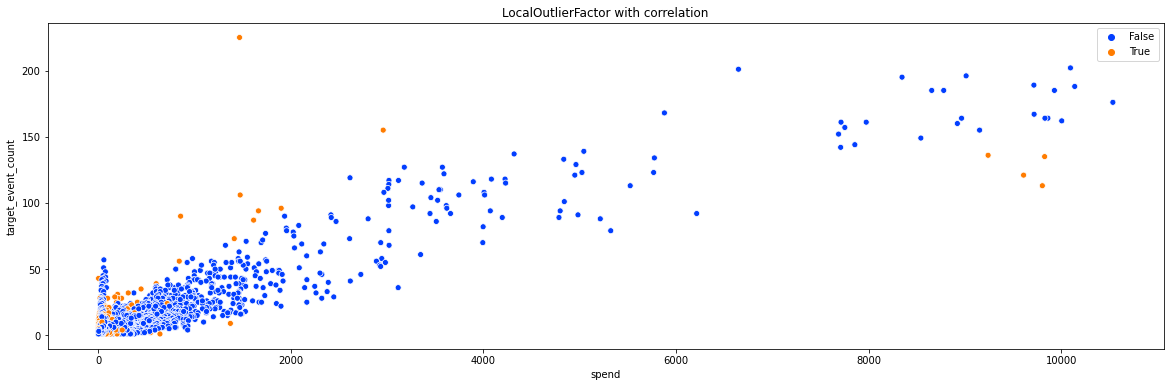

In [49]:
lof_corr = LocalOutlierFactor(n_neighbors=20, metric='correlation')
X = lof_corr.fit_predict(df_outliers) #np.sqrt(df_outliers))

plt.figure(figsize=(20,6))
sns.scatterplot(df.spend,
                df.target_event_count,
                hue=X==-1)
plt.title(f'LocalOutlierFactor with correlation');
plt.show()

Text(0.5, 1.0, 'Outlier factor')

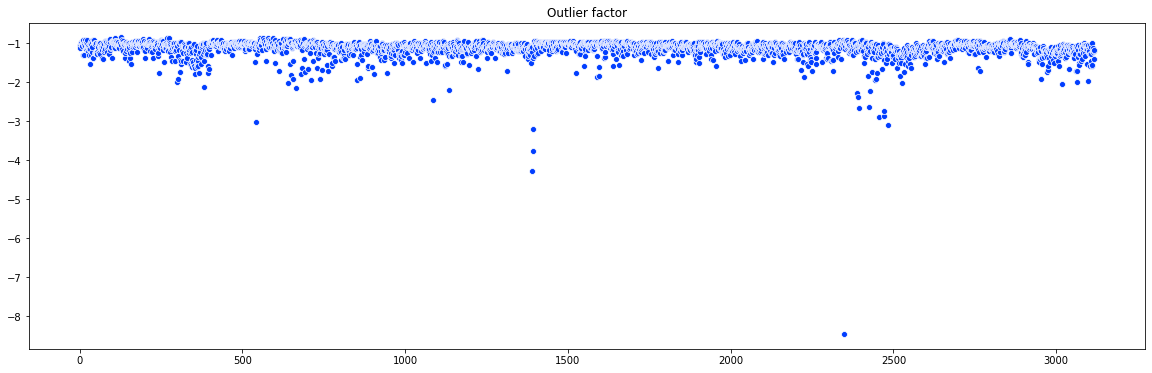

In [50]:
plt.figure(figsize=(20,6))
sns.scatterplot(range(len(lof_corr.negative_outlier_factor_)), lof_corr.negative_outlier_factor_)
plt.title('Outlier factor')

Probamos otro modelo usando como metrica [*mahalanobis*](https://es.wikipedia.org/wiki/Distancia_de_Mahalanobis), ya que es una "distancia euclidea" (y el algoritmo esta basado en distancias entre muestras) usando la correlacion de las variables.

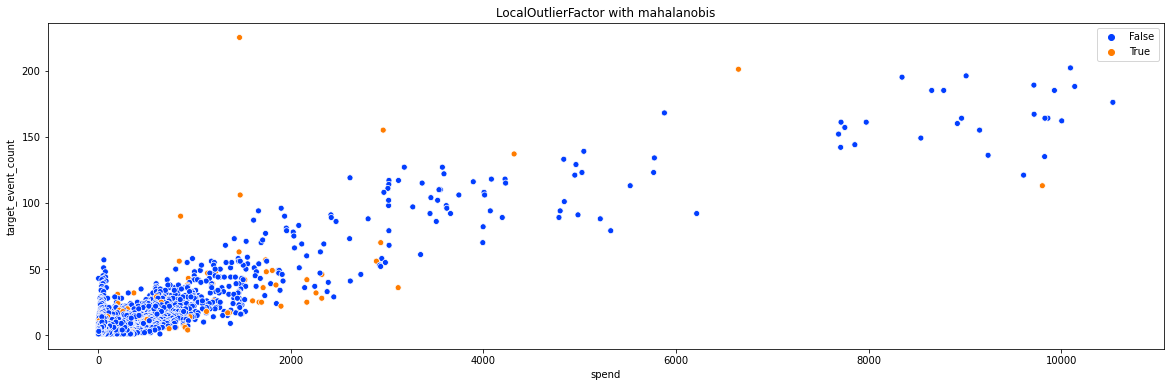

In [51]:
# del df_outliers['media_source_pinterest']
# del df_outliers['country_US']


lof_mah = LocalOutlierFactor(n_neighbors=20, algorithm='brute', 
                             metric='mahalanobis',
                             metric_params={'V': np.cov(df_outliers)})
X = lof_mah.fit_predict(df_outliers)
plt.figure(figsize=(20,6))
sns.scatterplot(df.spend,
                df.target_event_count,
                hue=X==-1)
plt.title(f'LocalOutlierFactor with mahalanobis');
plt.show()

Text(0.5, 1.0, 'Outlier factor')

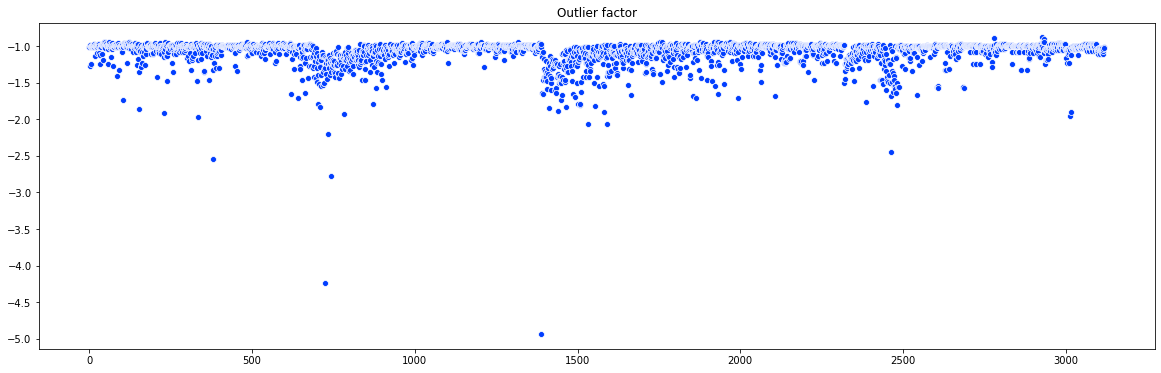

In [52]:
plt.figure(figsize=(20,6))
sns.scatterplot(range(len(lof_mah.negative_outlier_factor_)), lof_mah.negative_outlier_factor_)
plt.title('Outlier factor')

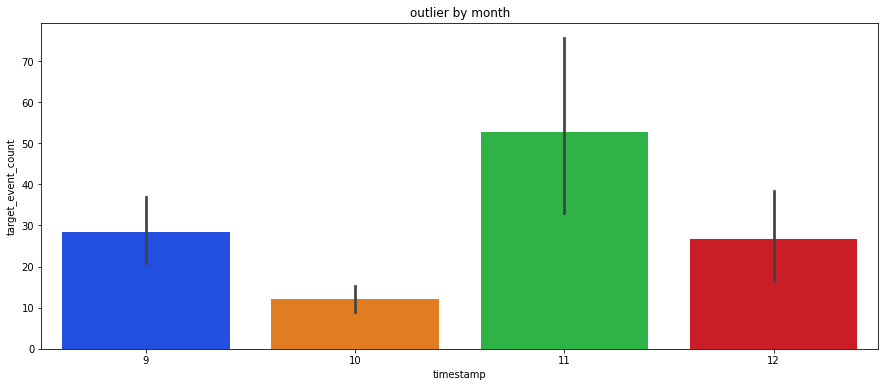

In [53]:
plt.figure(figsize=(15,6))
sns.barplot(df[lof_mah.negative_outlier_factor_ < -1.5].timestamp.dt.month, df[lof_mah.negative_outlier_factor_ < -1.5].target_event_count)
plt.title('outlier by month');

Con el modelo definido, lo usamos para borrar los outlier y lo guardamos en un pickle

In [54]:
df = df.loc[X!=-1]
df
# df.to_csv('Dataset_cleaned')

,app_id,timestamp,platform,country,media_source,spend,spend_currency,target_event_count
0,winclap.com,2020-09-12,android,AU,pinterest,100.00,USD,2
1,winclap.com,2020-12-06,android,AU,pinterest,300.00,USD,9
2,winclap.com,2020-12-05,android,AU,pinterest,300.00,USD,1
3,winclap.com,2020-12-04,android,AU,pinterest,300.00,USD,5
4,winclap.com,2020-09-11,android,AU,pinterest,100.00,USD,2
...,...,...,...,...,...,...,...,...
3113,winclap.com,2020-09-13,android,UK,google,2.37,USD,1
3114,winclap.com,2020-09-12,android,UK,google,2.22,USD,3
3115,winclap.com,2020-09-11,android,UK,google,6.03,USD,4
3116,winclap.com,2020-09-10,android,UK,google,3.44,USD,3


In [55]:
with open('lof_mah.pk', 'wb') as fp:
    import pickle
    pickle.dump(lof_mah, fp)